# OVRO–LWA two–stage SK analysis using `pygsk`

This notebook is the Jupyter equivalent of the standalone `ovro-lwa.py` example
script. It demonstrates a realistic two–stage Spectral Kurtosis (SK) workflow
for OVRO–LWA total–power data using **pyGSK ≥ 2.1.0**.

You can:
- Select an OVRO–LWA HDF5 file
- Choose polarization and SK parameters
- Optionally restrict the time range via `start_idx` and `ns_max`
- Optionally save plots and NPZ outputs with filenames that encode the time index range


## Configuration

In [4]:
# --- User configuration ---

# Path to OVRO-LWA HDF5 file (can be absolute or relative)
h5_path = r"C:\\Users\\gelu_\\Dropbox\\@Projects\\ovro-lwa\\application\\060963_182827094797b4e9492"

# Polarization to analyze: 'XX' or 'YY'
pol = "XX"

# Stage 1 SK parameters
M1 = 64          # integration length for Stage 1
N1 = 24          # number of spectra per block in Stage 1
d  = 1.0         # shape parameter for SK estimator

# Stage 2 SK parameters
M2 = 8           # integration length for Stage 2
# N2 will be computed as M1 * N1

# Probability of false alarm (one-sided)
pfa = 1e-3

# Output options
save_plot = False   # set True to save PNG plots
save_npz  = False   # set True to save NPZ outputs
outdir    = "./results"  # used only if saving files

# Time selection
start_idx = 0       # 0-based starting time index
ns_max    = 5000    # or None

# Plotting options forwarded to pygsk.runtests.run_sk_test
dpi         = 300
transparent = False
no_context  = False

scale   = "log"   # 'linear' or 'log' for context image
vmin    = None
vmax    = None
log_eps = None
cmap    = "viridis"

log_bins  = True
log_x     = True
log_count = False

print("Configuration loaded. Edit the cell above to adjust parameters.")

Configuration loaded. Edit the cell above to adjust parameters.


## Helper functions

In [5]:
from __future__ import annotations

import os
from datetime import datetime, timezone
from typing import Tuple, Optional, Dict, Any, List

import numpy as np
import h5py

from pygsk.runtests import run_sk_test


def load_h5(
    file_path: str,
    start_idx: int = 0,
    ns_max: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[np.ndarray], int, int, int]:
    """
    Load XX, YY, freq (Hz) and time (UTC seconds if available) from an OVRO-LWA
    single-tuning HDF5 file, with time slicing.

    Returns
    -------
    xx, yy : np.ndarray
        Power arrays with shape (ns_effective, nfreq).
    freq : np.ndarray
        Frequency array [nfreq] in Hz.
    time_sec : np.ndarray or None
        Time stamps [ns_effective] in seconds, or None if not present.
    start_idx_eff : int
        Effective starting index used.
    ns_effective : int
        Number of time frames actually read.
    ntime : int
        Total number of time frames available in the file.
    """
    with h5py.File(file_path, "r") as f:
        ds_xx = f["Observation1/Tuning1/XX"]
        ds_yy = f["Observation1/Tuning1/YY"]
        ds_freq = f["Observation1/Tuning1/freq"]

        ntime, nfreq = ds_xx.shape

        if start_idx < 0 or start_idx >= ntime:
            raise ValueError(
                f"start_idx={start_idx} is out of range for ntime={ntime}. "
                f"Valid range is 0 <= start_idx <= {ntime - 1}."
            )

        if ns_max is None:
            ns = ntime - start_idx
        else:
            if ns_max <= 0:
                raise ValueError("ns_max must be a positive integer if provided.")
            ns = min(ns_max, ntime - start_idx)

        if ns <= 0:
            raise ValueError(
                f"No samples selected: start_idx={start_idx}, ns_max={ns_max}, ntime={ntime}."
            )

        sl = slice(start_idx, start_idx + ns)

        xx = ds_xx[sl, :]
        yy = ds_yy[sl, :]
        freq = ds_freq[:]

        if freq.shape[0] != nfreq:
            raise ValueError(
                f"Frequency axis length {freq.shape[0]} does not match data nfreq={nfreq}"
            )

        time_sec: Optional[np.ndarray] = None
        if "Observation1/Tuning1/time" in f:
            ds_time = f["Observation1/Tuning1/time"]
            t = ds_time[sl]

            if np.issubdtype(t.dtype, np.number):
                time_sec = t.astype(float)
            else:
                t_str = np.array(t, dtype=str)

                def _parse_iso_to_unix(s: str) -> float:
                    if s.endswith("Z"):
                        s = s[:-1] + "+00:00"
                    dt = datetime.fromisoformat(s)
                    if dt.tzinfo is None:
                        dt = dt.replace(tzinfo=timezone.utc)
                    else:
                        dt = dt.astimezone(timezone.utc)
                    return dt.timestamp()

                time_sec = np.array([_parse_iso_to_unix(s) for s in t_str], dtype=float)

    print(
        f"[INFO] Loaded data slice: time indices [{start_idx}:{start_idx + ns}) "
        f"out of ntime={ntime} (ns_effective={ns})."
    )

    return xx, yy, freq, time_sec, start_idx, ns, ntime


def _npz_subset(d: Dict[str, Any], keys: List[str]) -> Dict[str, Any]:
    """Pick only keys that exist in the dictionary (for safe NPZ export)."""
    return {k: d[k] for k in keys if k in d}


def _maybe_add_time(payload: Dict[str, Any], key: str, t: Optional[np.ndarray], nrows: int) -> None:
    """Add a time-like array to `payload` only if it is 1-D and matches nrows."""
    if t is None:
        return
    t = np.asarray(t)
    if t.ndim == 1 and t.shape[0] == nrows:
        payload[key] = t
    else:
        print(f"[WARN] Skipping {key}: expected length {nrows}, got {t.shape}")


def _make_tag(prefix: str, time_tag: str, M: int, N: int, d: float, stage: str) -> str:
    """Generate a consistent base tag for filenames, including time index range."""
    return f"{prefix}_{time_tag}_M{M}_N{N}_d{d}_{stage}"

print("Helper functions defined.")

Helper functions defined.


## Run two-stage SK analysis

[INFO] No files will be written (no save_plot/save_npz).
[INFO] Loading HDF5: C:\\Users\\gelu_\\Dropbox\\@Projects\\ovro-lwa\\application\\060963_182827094797b4e9492
[INFO] Time selection: start_idx=0, ns_max=5000
[INFO] Loaded data slice: time indices [0:5000) out of ntime=299073 (ns_effective=5000).
[INFO] Using polarization: XX | power.shape=(5000, 3072) | nfreq=3072 | time_tag=t0-5000
[Stage 1] Computing s1/s2 via prepare_sk_input (M1=64, N=24, d=1.0) ...
[Stage 1] Running run_sk_test (no file save).
[run_sk_test] M=64 N=24 d=1.0 pfa=0.001
 thresholds: lo=0.541296 hi=1.66676
 empirical two-sided PFA=0.036016 vs expected=0.002


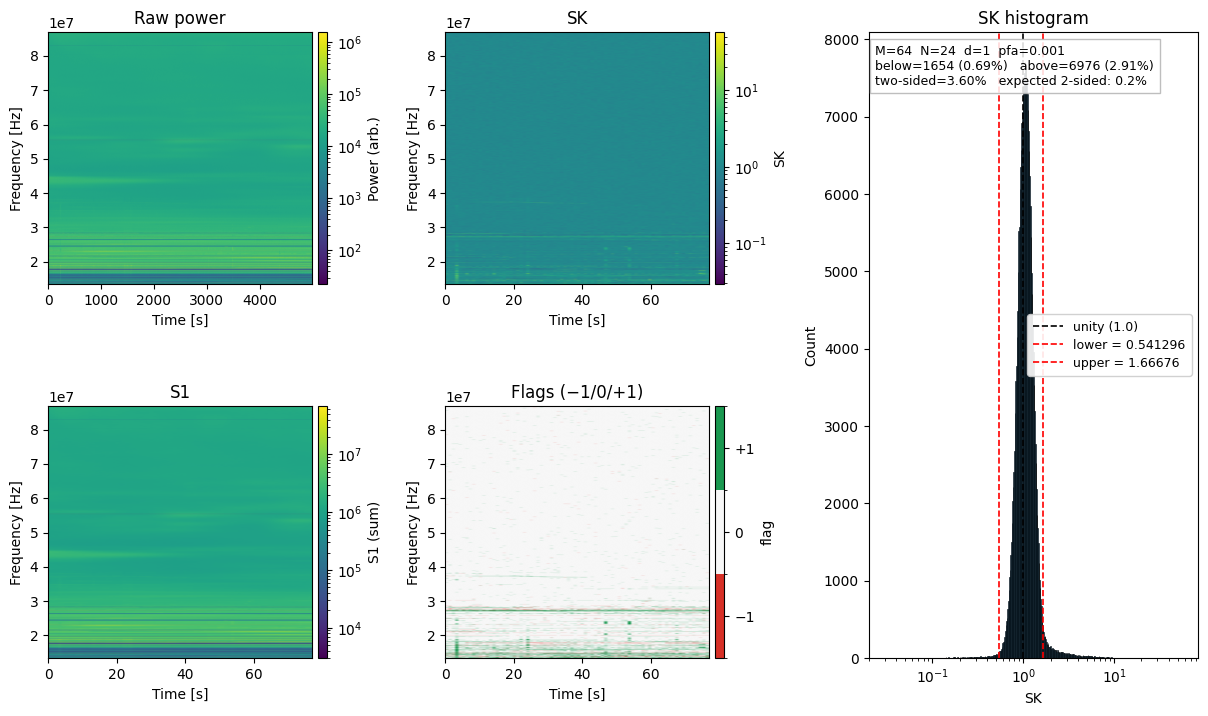

[Stage 2] Computing s1/s2 via prepare_sk_input (M2=8, N2=1536, d=1.0) ...
[Stage 2] Running run_sk_test (no file save).
[run_sk_test] M=8 N=1536 d=1.0 pfa=0.001
 thresholds: lo=0.0862025 hi=3.47595
 empirical two-sided PFA=0.145074 vs expected=0.002


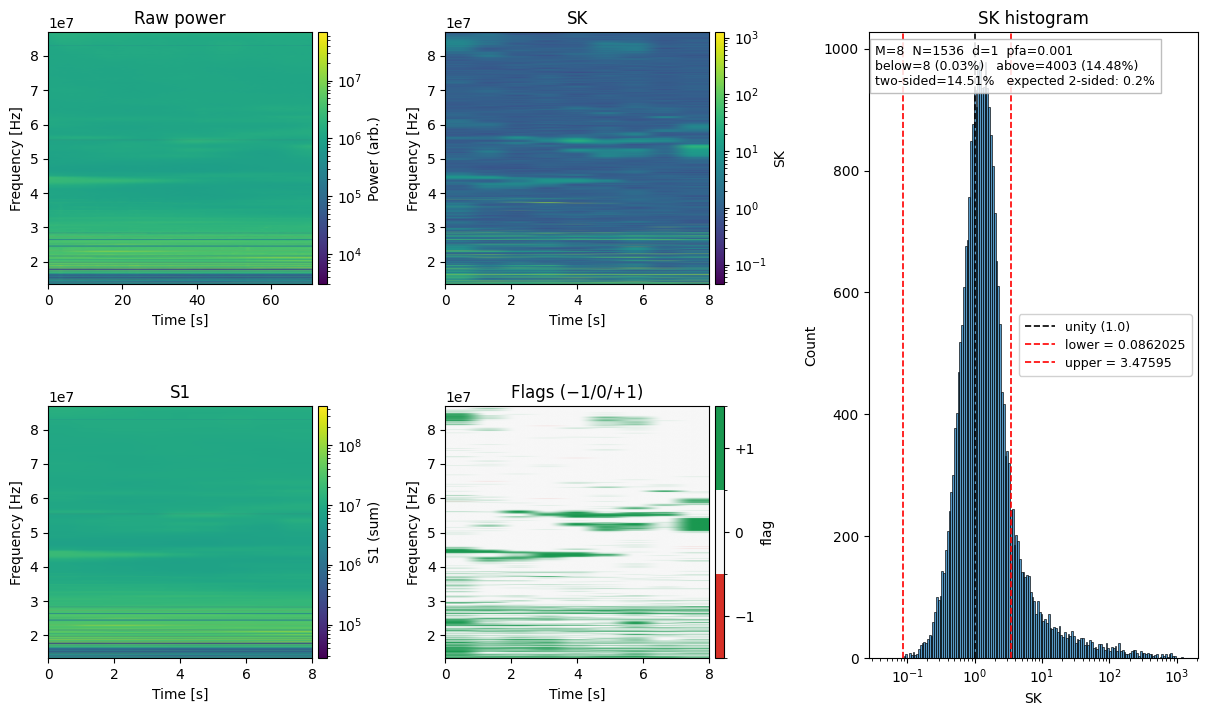

[SUMMARY] Stage 1 flags = 0.0360 (lo=0.541296, hi=1.66676)
[SUMMARY] Stage 2 flags = 0.1451 (lo=0.0862025, hi=3.47595)


In [6]:
# Resolve HDF5 path: allow bare basename → try .h5 / .hdf5.
if not os.path.exists(h5_path):
    candidates = [f"{h5_path}.h5", f"{h5_path}.hdf5"]
    existing = [c for c in candidates if os.path.exists(c)]
    if existing:
        h5_resolved = existing[0]
        print(f"[INFO] Input file not found, using candidate: {h5_resolved}")
    else:
        raise FileNotFoundError(
            f"Could not find HDF5 file at '{h5_path}' or any of {candidates}"
        )
else:
    h5_resolved = h5_path

# Decide if we actually need an output directory
need_outdir = save_plot or save_npz
if need_outdir:
    os.makedirs(outdir, exist_ok=True)
    print(f"[INFO] Output directory: {os.path.abspath(outdir)}")
else:
    print("[INFO] No files will be written (no save_plot/save_npz).")

# Load data (with time selection)
print(f"[INFO] Loading HDF5: {h5_resolved}")
if start_idx != 0 or ns_max is not None:
    print(f"[INFO] Time selection: start_idx={start_idx}, ns_max={ns_max}")

xx, yy, freq_hz, time_sec, start_eff, ns_eff, ntime = load_h5(
    h5_resolved,
    start_idx=start_idx,
    ns_max=ns_max,
)

power = xx if pol == "XX" else yy
base = os.path.splitext(os.path.basename(h5_resolved))[0]
prefix = f"{base}_{pol}"

# Time tag for filenames: t<start>-<stop>
stop_eff = start_eff + ns_eff
time_tag = f"t{start_eff}-{stop_eff}"

print(
    f"[INFO] Using polarization: {pol} | power.shape={power.shape} | "
    f"nfreq={freq_hz.shape[0]} | time_tag={time_tag}"
)

# ----------------
# Stage 1
# ----------------
print(f"[Stage 1] Computing s1/s2 via prepare_sk_input (M1={M1}, N={N1}, d={d}) ...")

pre1: Dict[str, Any] = {
    "power":   np.asarray(power, float),
    "freq":    np.asarray(freq_hz, float),
    "freq_hz": np.asarray(freq_hz, float),
    "M":       int(M1),
    "N":       int(N1),
    "d":       float(d),
}
_maybe_add_time(pre1, "time", time_sec, nrows=power.shape[0])

tag1 = _make_tag(prefix, time_tag, M1, N1, d, "stage1")

if save_plot:
    png1 = os.path.join(outdir, f"{tag1}_hist.png")
    save_path1: Optional[str] = png1
    print(f"[Stage 1] Running run_sk_test → {png1}")
else:
    save_path1 = None
    print("[Stage 1] Running run_sk_test (no file save).")

res1 = run_sk_test(
    precomputed=pre1,
    pfa=pfa,
    plot=True,
    save_path=save_path1,
    dpi=dpi,
    transparent=transparent,
    no_context=no_context,
    verbose=True,
    scale=scale,
    vmin=vmin,
    vmax=vmax,
    log_eps=log_eps,
    cmap=cmap,
    log_bins=log_bins,
    log_x=log_x,
    log_count=log_count,
)

if save_npz:
    npz1 = os.path.join(outdir, f"{tag1}_data.npz")
    np.savez(
        npz1,
        **_npz_subset(
            res1,
            [
                "power",
                "s1_map",
                "sk_map_raw",
                "flags_map",
                "lower_raw",
                "upper_raw",
                "M",
                "N",
                "d",
                "time",
                "time_blk",
                "freq_hz",
            ],
        ),
    )
    print(f"[Stage 1] Saved NPZ: {npz1}")

# ----------------
# Stage 2
# ----------------
power2 = res1["s1"]
N2 = int(M1 * N1)
time_blk = res1.get("time_blk", None)

print(f"[Stage 2] Computing s1/s2 via prepare_sk_input (M2={M2}, N2={N2}, d={d}) ...")

pre2_payload: Dict[str, Any] = {
    "power":   np.asarray(power2, float),
    "freq":    np.asarray(freq_hz, float),
    "freq_hz": np.asarray(freq_hz, float),
    "M":       int(M2),
    "N":       N2,
    "d":       float(d),
}
_maybe_add_time(pre2_payload, "time", time_blk, nrows=power2.shape[0])

tag2 = _make_tag(prefix, time_tag, M2, N2, d, "stage2")

if save_plot:
    png2 = os.path.join(outdir, f"{tag2}_hist.png")
    save_path2: Optional[str] = png2
    print(f"[Stage 2] Running run_sk_test → {png2}")
else:
    save_path2 = None
    print("[Stage 2] Running run_sk_test (no file save).")

res2 = run_sk_test(
    precomputed=pre2_payload,
    pfa=pfa,
    plot=True,
    save_path=save_path2,
    dpi=dpi,
    transparent=transparent,
    no_context=no_context,
    verbose=True,
    scale=scale,
    vmin=vmin,
    vmax=vmax,
    log_eps=log_eps,
    cmap=cmap,
    log_bins=log_bins,
    log_x=log_x,
    log_count=log_count,
)

if save_npz:
    npz2 = os.path.join(outdir, f"{tag2}_data.npz")
    np.savez(
        npz2,
        **_npz_subset(
            res2,
            [
                "power",
                "s1_map",
                "sk_map_raw",
                "flags_map",
                "lower_raw",
                "upper_raw",
                "M",
                "N",
                "d",
                "time",
                "time_blk",
                "freq_hz",
            ],
        ),
    )
    print(f"[Stage 2] Saved NPZ: {npz2}")

# ----------------
# Summary
# ----------------
f1, f2 = res1["flags_map"], res2["flags_map"]
frac1 = np.count_nonzero(f1) / f1.size
frac2 = np.count_nonzero(f2) / f2.size

print(
    f"[SUMMARY] Stage 1 flags = {frac1:.4f} "
    f"(lo={res1['lower_raw']:.6g}, hi={res1['upper_raw']:.6g})"
)
print(
    f"[SUMMARY] Stage 2 flags = {frac2:.4f} "
    f"(lo={res2['lower_raw']:.6g}, hi={res2['upper_raw']:.6g})"
)